In [1]:
from dataset.dataset import *
from models.involution import * 
from models.unet import *

In [2]:
import math
import numpy as np
import torch 
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import glob

import matplotlib.pyplot as plt
import os 
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import datetime
import logging

In [3]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_data_dir = "./dataset/foggy_cityscape/train"
test_data_dir = "./dataset/foggy_cityscape/test"
train_dataset = FoggyCityscape(train_data_dir, transform)
test_dataset = FoggyCityscape(test_data_dir, transform)

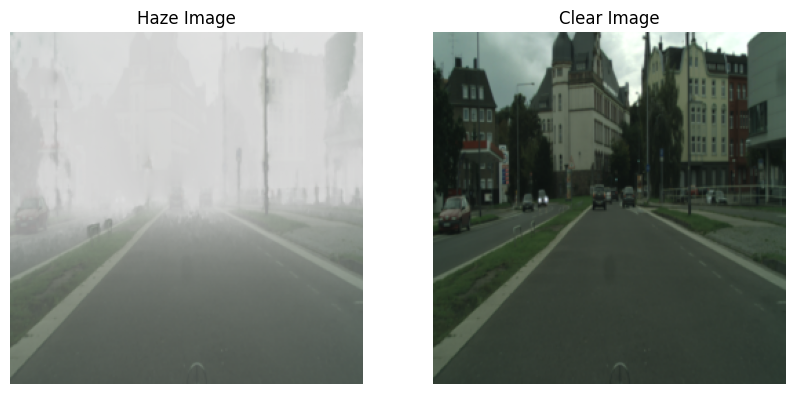

In [4]:
# Access an item from the dataset
index = 1  # Change this to test different images
haze_image, clear_image= train_dataset[index]

# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [5]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle=True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = batch_size,
                       num_workers = 4)

In [6]:
first_batch = next(iter(train_loader))

# Assuming the batch is a tuple of (inputs, targets)
images, labels = first_batch

# Get the shape of the first image in the batch
first_image_shape = images[0].shape

print(f"The dimension of the first image: {first_image_shape}")

The dimension of the first image: torch.Size([3, 256, 256])


# Testing the models

## Involution

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    x = torch.randn((4, 3, 256, 256)).to(device)
    model = UNET(in_channels = 3, out_channels = 3).to(device)
    preds = model(x)
    print(preds.shape)

if __name__ == "__main__":
    test()


torch.Size([4, 3, 256, 256])


In [8]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

In [9]:
from tqdm.notebook import tqdm

def train_per_epoch(model, train_loader, criterion, 
                    optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for xs, ys in train_bar:
        xs = xs.to(device)
        ys = ys.to(device)
        
        preds = model(xs)
        loss = criterion(preds, ys)  # Compute loss using model predictions
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update tqdm bar with the current loss
        train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = total_loss / len(train_loader)
    # print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")
    return avg_train_loss

In [10]:
def valid_per_epoch(model, val_loader, criterion, device, epoch, 
                    num_epochs, val_logger, batch_size = 32):
    
    model.eval()
    total_psnr = 0.0
    total_val_loss = 0.0
    total_ssim = 0.0  # Initialize SSIM accumulator
    running_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False)

    val_logger.info(f"Epoch {epoch+1}/{num_epochs}")
    batch_num = 0
    with torch.no_grad():
        for xs, ys in val_bar:
            xs = xs.to(device)
            ys = ys.to(device)
            preds = model(xs)
            loss = criterion(preds, ys)
            total_val_loss += loss.item()
            
            psnr_score = psnr(ys, preds)
            total_psnr += psnr_score
            
            ssim_batch = 0
            # Convert tensors to numpy arrays and compute SSIM
            for i in range(xs.shape[0]):  # Iterate over batch dimension
                ys_np = ys[i].cpu().numpy().squeeze().transpose((1, 2, 0))  # Convert PyTorch tensor to numpy array
                preds_np = preds[i].cpu().numpy().squeeze().transpose((1, 2, 0))  # Convert PyTorch tensor to numpy array

                # max_val = max(ys_np.max(), preds_np.max())
                # min_val = min(ys_np.min(), preds_np.min())
                # data_range = max_val - min_val

                # print(ys_np)
                # print(preds_np)

                # The range of the ssim of the float image is 0 to 1
                ssim_score = ssim(ys_np, preds_np, data_range = 1,
                                  multichannel = True, channel_axis = -1)  # Compute SSIM
                total_ssim += ssim_score
                ssim_batch += ssim_score

            # Update tqdm bar with the current loss
            val_bar.set_postfix(
                loss = loss.item(),
                psnr = psnr_score.item(),
                ssim = ssim_batch / batch_size
            )
            
            val_logger.info(f"Batch num: {batch_num}")
            val_logger.info(f"Loss: {loss.item()}, PSNR: {psnr_score.item()}, SSIM: {ssim_batch / batch_size}")
            # if loss.item() >= 1:
            #     val_logger.warning(f"High loss observed: {loss.item()}")
            #     val_logger.warning(f"Predictions: {preds.cpu().numpy()}")
            #     val_logger.warning(f"Ground Truth: {ys.cpu().numpy()}")

            batch_num += 1

    avg_val_loss = total_val_loss / len(val_loader)
    avg_psnr = total_psnr / len(val_loader)
    avg_ssim = total_ssim / (len(val_loader) * batch_size)  # Calculate average SSIM
    
    # print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

    return avg_val_loss, avg_psnr, avg_ssim 

In [11]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, 
                       num_epochs, device, train_log, val_log, batch_size = 32):
    
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'psnr': [], 'ssim': []}
    
    # Create a timestamp for the model filename
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    os.makedirs("weights", exist_ok = True)
    model_path = f"weights/model_{timestamp}.pth"
    
    for epoch in range(num_epochs):
        train_loss = train_per_epoch(model, train_loader, criterion, 
                                     optimizer, device, epoch, num_epochs)
        val_loss, psnr, ssim = valid_per_epoch(model, val_loader, criterion,
                                                  device, epoch, num_epochs, val_log, batch_size = batch_size)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['psnr'].append(psnr)
        history['ssim'].append(ssim)
        
        # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PSNR: {psnr}, SSIM: {ssim}")

        train_log.info(f"Epoch {epoch+1}/{num_epochs}")
        train_log.info(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PSNR: {psnr}, SSIM: {ssim}")
        
        # Save the model if it has the best validation loss so far
        torch.save(model.state_dict(), model_path)
        print(f"Model saved as {model_path}")
    
    return history

In [12]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)

# # Set up logging to file and console
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s

# train_logger = logging.getLogger()
# file_handler = logging.FileHandler(log_file)
# file_handler.setLevel(logging.INFO)
# file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
# train_logger.addHandler(file_handler)

# val_logger = logging.getLogger()
# val_handler = logging.FileHandler(val_logfile)
# val_handler.setLevel(logging.INFO)
# val_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
# val_logger.addHandler(val_handler)

In [13]:
# train_log.info("Hello Train")
# val_log.info("Hello Val")

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNET(in_channels = 3, out_channels = 3).to(device)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

history = train_and_evaluate(model, train_loader, test_loader, criterion, 
                             optimizer, epochs, device, train_log, val_log, batch_size)

In [15]:
print("Hello LOL")

Hello LOL


In [16]:
print(model)

UNET(
  (downs): ModuleList(
    (0): UNET_block(
      (convblock): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): GELU(approximate='none')
      )
      (involution): Sequential(
        (0): Involution_CUDA(
          (conv1): ConvModule(
            (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2d): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv2): ConvModule(
            (conv2d): Conv2d(16, 3136, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (convblock2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (gelu): GELU(approximate='none')
   

## Testing

In [29]:
def test_case(test_dataset, model, model_path = 'weights/model_20240516_075609.pth'):

    haze_image, clean_image = test_dataset
    haze_image, clean_image = haze_image.to(device), clean_image.to(device)
    
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        denoised_image = model(haze_image.unsqueeze(0).cuda())
        print(f"PSNR:{psnr(denoised_image, clean_image.to(device))}")
    
    
    # Convert PyTorch tensors to numpy arrays
    haze_np = haze_image.permute(1, 2, 0).cpu().numpy()  # Assuming haze_image is a PyTorch tensor
    denoised_np = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming denoised_image is a PyTorch tensor
    clean_np = clean_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming clean_image is a PyTorch tensor
    
    # Calculate SSIM
    ssim_value = ssim(denoised_np, clean_np, 
                      multichannel = True, channel_axis = -1, data_range = 1)
     # Assuming images are in RGB format
    print(f"SSIM: {ssim_value}")
    
    # Plot the haze image, denoised image, and clean image
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    axes[0].imshow(haze_np)
    axes[0].set_title('Haze Image')
    axes[0].axis('off')
    
    axes[1].imshow(denoised_np)
    axes[1].set_title('Denoised Image')
    axes[1].axis('off')
    
    axes[2].imshow(clean_np)
    axes[2].set_title('Clean Image')
    axes[2].axis('off')
    
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:22.244054794311523
SSIM: 0.8123459219932556


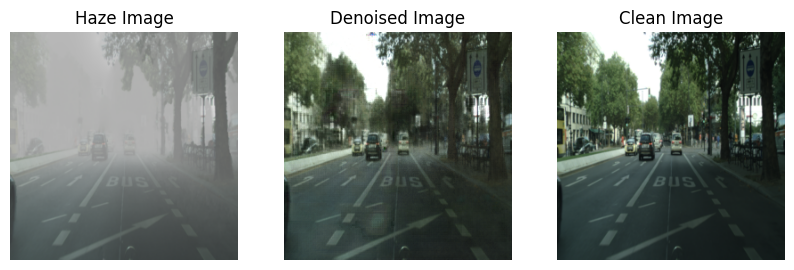

In [30]:
test_case(test_dataset[0], model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:25.636104583740234
SSIM: 0.8867993950843811


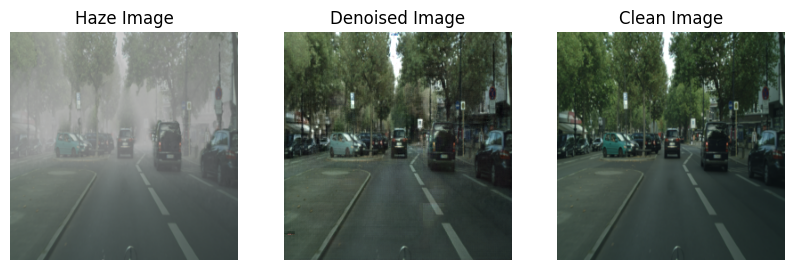

In [32]:
test_case(test_dataset[1], model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.650400161743164
SSIM: 0.7971760630607605


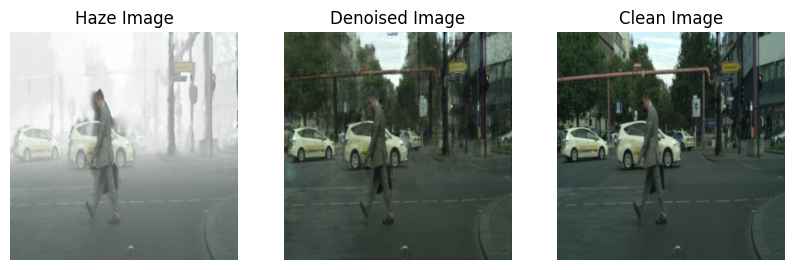

In [33]:
test_case(test_dataset[2], model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.688880920410156
SSIM: 0.8624631762504578


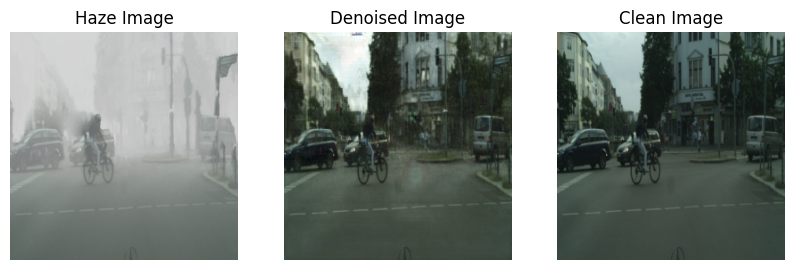

In [34]:
test_case(test_dataset[3], model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:18.450529098510742
SSIM: 0.7990322709083557


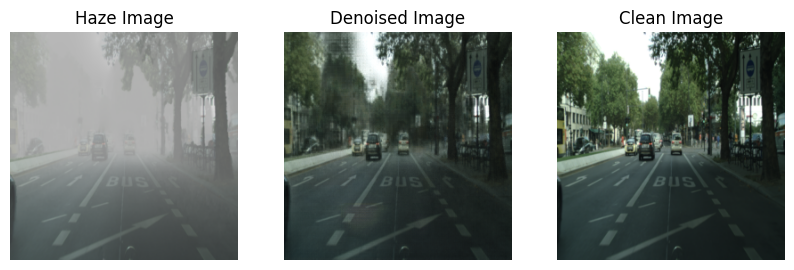

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:26.661399841308594
SSIM: 0.8982775211334229


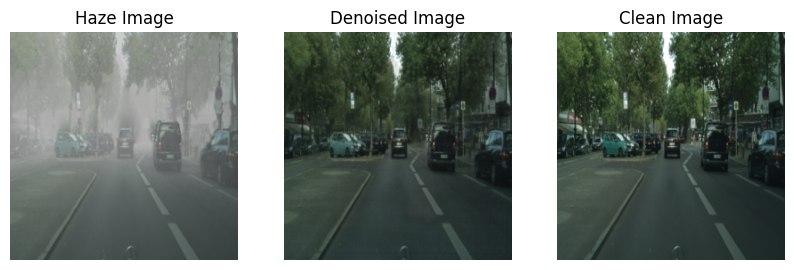

/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: overflow encountered in multiply
  uxx = filter_func(im1 * im1, **filter_args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:-inf
SSIM: nan


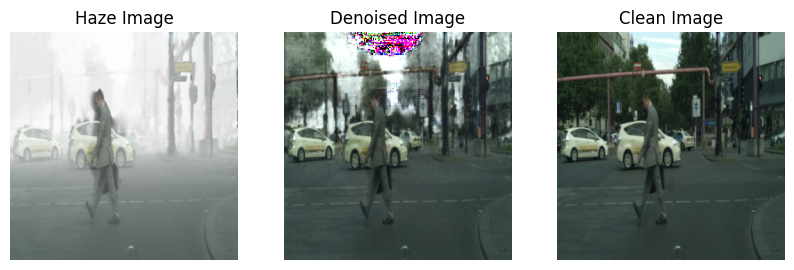

PSNR:25.299856185913086
SSIM: 0.8768141269683838


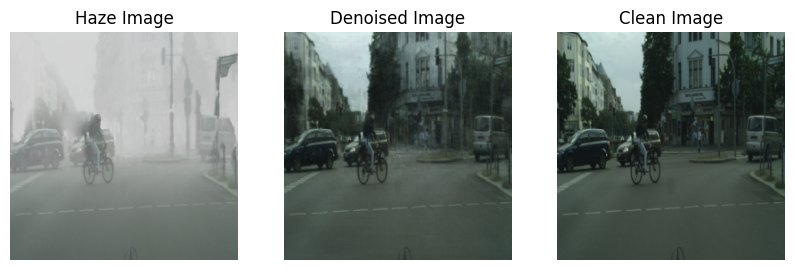

PSNR:29.20783042907715
SSIM: 0.9228692054748535


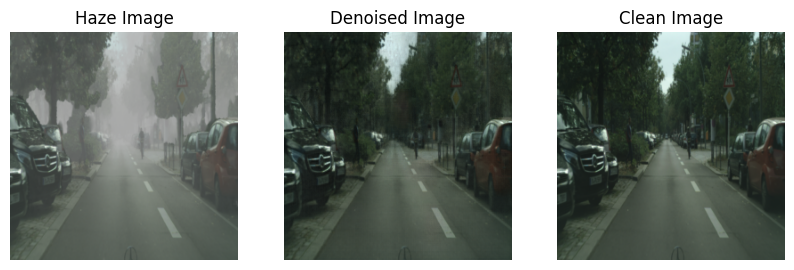

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:-52.9127197265625
SSIM: 0.8747002482414246


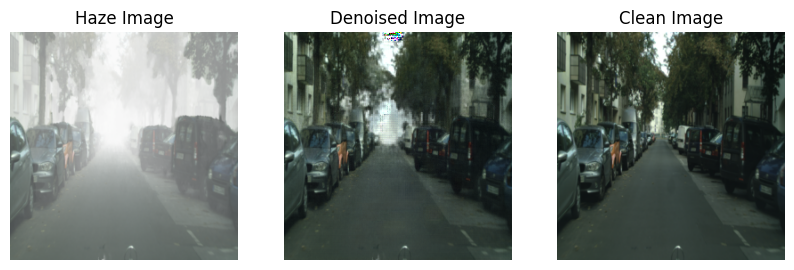

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:29.046974182128906
SSIM: 0.9174716472625732


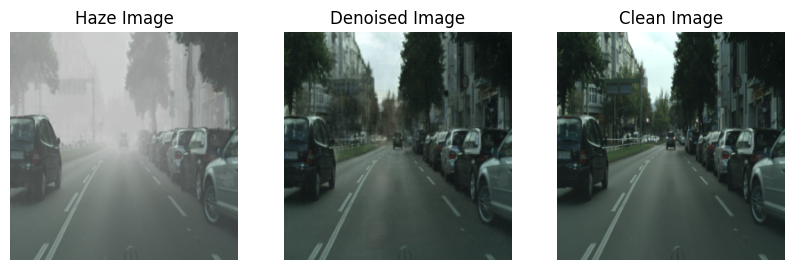

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:18.73798370361328
SSIM: 0.8120937943458557


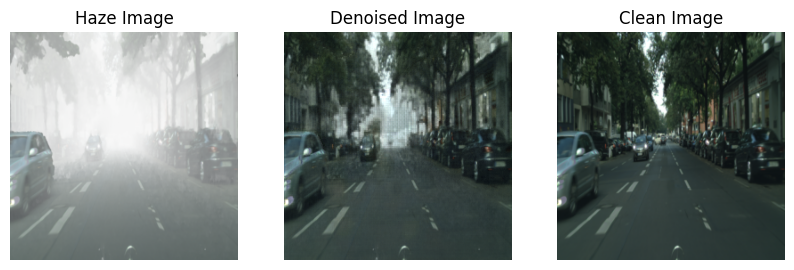

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:24.29878044128418
SSIM: 0.8774862289428711


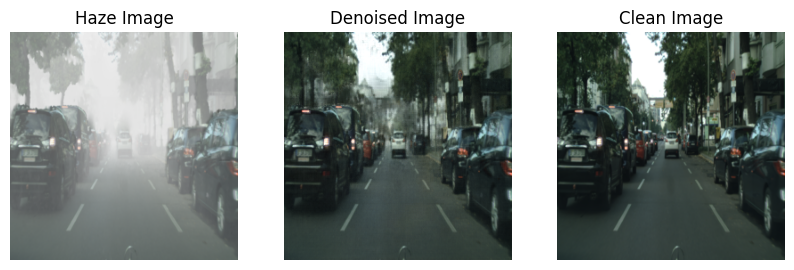

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:25.047876358032227
SSIM: 0.8679428696632385


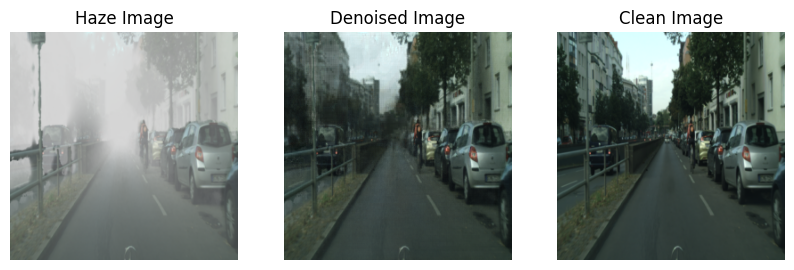

In [46]:
def inference_lol(test_dataset, model, model_path = 'weights/model_20240516_075609.pth'):

    for i in range(100):
        haze_image, clean_image = test_dataset[i]
        haze_image, clean_image = haze_image.to(device), clean_image.to(device)
        
        model = model.to(device)
        model.load_state_dict(torch.load(model_path))
        
        with torch.no_grad():
            denoised_image = model(haze_image.unsqueeze(0).cuda())
            print(f"PSNR:{psnr(denoised_image, clean_image.to(device))}")
        
        
        # Convert PyTorch tensors to numpy arrays
        haze_np = haze_image.permute(1, 2, 0).cpu().numpy()  # Assuming haze_image is a PyTorch tensor
        denoised_np = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming denoised_image is a PyTorch tensor
        clean_np = clean_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming clean_image is a PyTorch tensor
        
        # Calculate SSIM
        ssim_value = ssim(denoised_np, clean_np, 
                          multichannel = True, channel_axis = -1, data_range = 1)
         # Assuming images are in RGB format
        print(f"SSIM: {ssim_value}")
        
        # Plot the haze image, denoised image, and clean image
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        
        axes[0].imshow(haze_np)
        axes[0].set_title('Haze Image')
        axes[0].axis('off')
        
        axes[1].imshow(denoised_np)
        axes[1].set_title('Denoised Image')
        axes[1].axis('off')
        
        axes[2].imshow(clean_np)
        axes[2].set_title('Clean Image')
        axes[2].axis('off')
        
        plt.show()

inference_lol(test_dataset, model)